<a href="https://colab.research.google.com/github/madara-tribe/AlphaZero_TicTacToe/blob/master/more_filter_must_16N.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from keras import optimizers
## Import usual libraries
import tensorflow as tf
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras import backend
from datetime import datetime #DB
import gc #DB
from tqdm import tqdm
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
warnings.filterwarnings("ignore")


import tensorflow as tf
import sys, time, warnings
import keras as keras
from keras.models import *
from keras.layers import *
#from keras.utils import plot_model #DB
warnings.filterwarnings("ignore")


IMAGE_ORDERING =  "channels_last"

#Function to add 2 convolutional layers with the parameters passed to it
def conv2d_block(inits, n_filters, kernel_size = 3, batchnorm = True, activation=True):
    #firt layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same', data_format=IMAGE_ORDERING)(inits)
    if batchnorm:
        x = BatchNormalization()(x)
    if activation:
        x = Activation('relu')(x)
    return x



def UNET_v2( nClasses, input_height, input_width, n_filters=16*2, dropout=0.1,
          batchnorm=True, activation=True):
    N = 30
    ## input_height and width must be devisible by 16 because maxpooling with filter size = (2,2) is operated 4 times,
    ## which makes the input_height and width 2^4 = 16 times smaller
    assert input_height%16 == 0
    assert input_width%16 == 0

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    ## Downscaling

    ## Block 1: 64, 64
    c1 = conv2d_block(img_input, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c1x = conv2d_block(img_input, (n_filters * 1)+N, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c1y = conv2d_block(img_input, (n_filters * 1)+2*N, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c1  = Concatenate(axis=3)([c1, c1x, c1y])
    c1 = Conv2D(filters = n_filters * 1, kernel_size = (3, 3), kernel_initializer = 'he_normal', 
              padding = 'same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1) # 112x112x64

    ## Block 2: 128, 128
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c2x = conv2d_block(p1, (n_filters * 2)+N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c2y = conv2d_block(p1, (n_filters * 2)+2*N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c2  = Concatenate(axis=3)([c2, c2x, c2y])
    c2 = Conv2D(filters = n_filters * 2, kernel_size = (3, 3), kernel_initializer = 'he_normal', 
                  padding = 'same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2) # 56x56x128

    ## Block 3: 256, 256
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c3x = conv2d_block(p2, (n_filters * 4)+N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c3y = conv2d_block(p2, (n_filters * 4)+2*N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c3  = Concatenate(axis=3)([c3, c3x, c3y])
    c3 = Conv2D(filters = n_filters * 4, kernel_size = (3, 3), kernel_initializer = 'he_normal', 
              padding = 'same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3) # 28x28x256

    ## Block 4: 512, 512
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c4x = conv2d_block(p3, (n_filters * 8)+N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c4y = conv2d_block(p3, (n_filters * 8)+2*N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c4  = Concatenate(axis=3)([c4, c4x, c4y])
    c4 = Conv2D(filters = n_filters * 8, kernel_size = (3, 3), kernel_initializer = 'he_normal', 
              padding = 'same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4) # 14x14x512

    ## Block5: 1024, 1024
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c5x = conv2d_block(p4, (n_filters * 16)+N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c5y = conv2d_block(p4, (n_filters * 16)+2*N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c5  = Concatenate(axis=3)([c5, c5x, c5y])
    c5 = Conv2D(filters = n_filters * 16, kernel_size = (3, 3), kernel_initializer = 'he_normal', 
              padding = 'same')(c5)
    p5 = Dropout(dropout)(c5) # 14x14x1024
    ## Upscaling

    ## Block6: 512, 512
    up6 = UpSampling2D(size=(2, 2),data_format=IMAGE_ORDERING, interpolation="bilinear")(p5) # 28x28x1024
    u6 = Conv2D(filters=n_filters*8, kernel_size=2, data_format=IMAGE_ORDERING,
              activation="relu", padding="same", kernel_initializer="he_normal")(up6)
    m6 = Concatenate(axis=3)([u6, c4])
    m6 = Dropout(dropout)(m6)
    c6 = conv2d_block(m6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c6x = conv2d_block(m6, (n_filters * 8)+N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c6y = conv2d_block(m6, (n_filters * 8)+2*N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c6  = Concatenate(axis=3)([c6, c6x, c6y])
    c6 = Conv2D(filters = n_filters * 8, kernel_size = (3, 3), kernel_initializer = 'he_normal', 
              padding = 'same')(c6)
          
    ## Block7: 256, 256
    up7 = UpSampling2D(size=(2, 2),data_format=IMAGE_ORDERING, interpolation="bilinear")(c6) #56x56x256
    u7 = Conv2D(filters=n_filters*4, kernel_size=2, data_format=IMAGE_ORDERING,
              activation="relu", padding="same", kernel_initializer="he_normal")(up7)
    m7 = Concatenate(axis=3)([u7, c3])
    m7 = Dropout(dropout)(m7)
    c7 = conv2d_block(m7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c7x = conv2d_block(m7, (n_filters * 4)+N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c7y = conv2d_block(m7, (n_filters * 4)+2*N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c7  = Concatenate(axis=3)([c7, c7x, c7y])
    c7 = Conv2D(filters = n_filters * 4, kernel_size = (3, 3), kernel_initializer = 'he_normal', 
              padding = 'same')(c7)

    ## Block8: 128, 128
    up8 = UpSampling2D(size=(2, 2),data_format=IMAGE_ORDERING, interpolation="bilinear")(c7) # 112x112x128
    u8  = Conv2D(filters=n_filters*2, kernel_size=2, data_format=IMAGE_ORDERING,
              activation="relu", padding="same", kernel_initializer="he_normal")(up8)
    m8  = Concatenate(axis=3)([u8, c2])
    m8  = Dropout(dropout)(m8)
    c8 = conv2d_block(m8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c8x = conv2d_block(m8, (n_filters * 2)+N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c8y = conv2d_block(m8, (n_filters * 2)+2*N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c8  = Concatenate(axis=3)([c8, c8x, c8y])
    c8 = Conv2D(filters = n_filters * 2, kernel_size = (3, 3), kernel_initializer = 'he_normal', 
              padding = 'same')(c8)

    ## Block9: 64, 64
    up9 = UpSampling2D(size=(2, 2),data_format=IMAGE_ORDERING, interpolation="bilinear")(c8) # 224x224x64
    u9  = Conv2D(filters=n_filters*1, kernel_size=2, data_format=IMAGE_ORDERING,
              activation="relu", padding="same", kernel_initializer="he_normal")(up9)
    m9 = Concatenate(axis=3)([u9, c1])
    m9 = Dropout(dropout)(m9)
    c9 = conv2d_block(m9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm, activation=activation)
    c9x = conv2d_block(m9, (n_filters * 1)+N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c9y = conv2d_block(m9, (n_filters * 1)+2*N, kernel_size = 3, batchnorm = batchnorm,  activation=activation)
    c9  = Concatenate(axis=3)([c9, c9x, c9y])

    ## Last layers
    c10 = Conv2D(filters=nClasses, kernel_size=1, data_format=IMAGE_ORDERING, activation="sigmoid")(c9)
    model = Model(inputs=img_input, outputs=c10)

    return model
	

HEIGHT = int((1216/4)-160)
WIDTH  = int((1920/4)-160) 
print(HEIGHT, WIDTH)
N_CLASSES = 5
FINE_N_CLASSES = 5
BATCH_SIZE = 2
EPOCHS = 15


model = UNET_v2(N_CLASSES, HEIGHT, WIDTH)

FINE_N_CLASSES = 5
def create_fintune_model(model, nClasses=FINE_N_CLASSES):
    inputs_ = model.inputs
    dense = model.get_layer(index=-2).output
    o1 = Conv2DTranspose(nClasses, kernel_size=(1,1), strides=(1,1), use_bias=False)(dense)
    o = (Activation("softmax"))(o1)
    models = Model(inputs=inputs_, outputs=o)
    return models



model = create_fintune_model(model, FINE_N_CLASSES)
#model.load_weights('keras_model/ep500_trained_unet_model2_224x224.hdf5')
model.summary()

144 320
Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 144, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d_267 (Conv2D)             (None, 144, 320, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_268 (Conv2D)             (None, 144, 320, 62) 1736        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_269 (Conv2D)             (None, 144, 320, 92) 2576        input_7[0][0]                    
______________________________________________________________________________

In [25]:
path= '/content/drive/My Drive/'
dir_train_img=path+'4cls/train'
dir_train_seg=path+'4cls/anno'
dir_valid_img =path+ '4cls/val'
dir_valid_seg =path+ '4cls/val_anno'

In [26]:
# load training images

def NormalizeImageArr(path, H, W):
    NORM_FACTOR = 255
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (H, W), interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32)
    img = img/NORM_FACTOR
    return img

def LoadSegmentationArr( path , nClasses,  width ,height):
    seg_labels = np.zeros((height, width, nClasses))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, : , 0]
    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    return seg_labels

# load training images
train_images = os.listdir(dir_train_img)
train_images.sort()
train_segmentations  = os.listdir(dir_train_seg)
train_segmentations.sort()
X_train, Y_train=[], []
X_train2, Y_train2=[], []

for im , seg in tqdm(zip(train_images,train_segmentations)):
    X_train.append(NormalizeImageArr(os.path.join(dir_train_img,im), WIDTH, HEIGHT))
    Y_train.append(LoadSegmentationArr( os.path.join(dir_train_seg,seg) , FINE_N_CLASSES, WIDTH, HEIGHT)  )



def fliplr_image(X, Y):
    Xflip =np.array([img[:, ::-1] for img in X])
    Yflip =np.array([img[:, ::-1] for img in Y])
    return Xflip, Yflip




print('train load')
X_train, Y_train = np.array(X_train), np.array(Y_train)

print(X_train.shape,Y_train.shape)
print(X_train.max(), X_train.min())
print(Y_train.max(), Y_train.min())

# In[13]:


# load validation images
valid_images = os.listdir(dir_valid_img)
valid_images.sort()
valid_segmentations  = os.listdir(dir_valid_seg)
valid_segmentations.sort()
X_valid, Y_valid = [], []

for im , seg in tqdm(zip(valid_images,valid_segmentations)):
    X_valid.append( NormalizeImageArr(os.path.join(dir_valid_img,im), WIDTH, HEIGHT) )
    Y_valid.append( LoadSegmentationArr( os.path.join(dir_valid_seg,seg) , FINE_N_CLASSES, WIDTH, HEIGHT))

X_valid, Y_valid = np.array(X_valid) , np.array(Y_valid)

print(X_valid.shape,Y_valid.shape)
print(X_valid.max(),X_valid.min())

20it [00:01, 18.22it/s]
2it [00:00, 17.12it/s]

train load
(20, 144, 320, 3) (20, 144, 320, 5)
1.0 0.0
1.0 0.0


10it [00:00, 17.45it/s]

(10, 144, 320, 3) (10, 144, 320, 5)
1.0 0.0


Epoch 1/200
10/10 [==============================] - 2s 225ms/step - loss: 0.1213 - accuracy: 0.9553 - val_loss: 1.6492 - val_accuracy: 0.7099
Epoch 2/200
10/10 [==============================] - 2s 168ms/step - loss: 0.0974 - accuracy: 0.9639 - val_loss: 1.3929 - val_accuracy: 0.7276
Epoch 3/200
10/10 [==============================] - 2s 169ms/step - loss: 0.0798 - accuracy: 0.9707 - val_loss: 0.7432 - val_accuracy: 0.8500
Epoch 4/200
10/10 [==============================] - 2s 170ms/step - loss: 0.0696 - accuracy: 0.9727 - val_loss: 1.1041 - val_accuracy: 0.7993
Epoch 5/200
10/10 [==============================] - 2s 171ms/step - loss: 0.0693 - accuracy: 0.9736 - val_loss: 0.6633 - val_accuracy: 0.8627
Epoch 6/200
10/10 [==============================] - 2s 171ms/step - loss: 0.0549 - accuracy: 0.9795 - val_loss: 0.7919 - val_accuracy: 0.8026
Epoch 7/200
10/10 [==============================] - 2s 172ms/step - loss: 0.0562 - accuracy: 0.9785 - val_loss: 0.5309 - val_accuracy: 0.8733

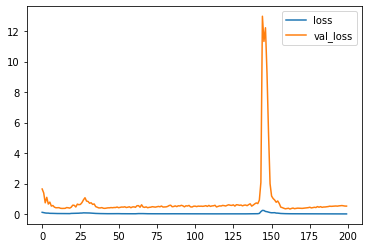

In [31]:
adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


# In[18]:


startTime1 = datetime.now() #DB
hist1 = model.fit(X_train,Y_train, validation_data=(X_valid,Y_valid), batch_size=2,
                  epochs=200)
endTime1 = datetime.now()
diff1 = endTime1 - startTime1
print("\n")
print("Elapsed time for Keras training (s): ", diff1.total_seconds())
print("\n")

for key in ["loss", "val_loss"]:
    plt.plot(hist1.history[key],label=key)
plt.legend()

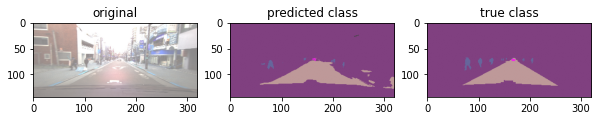

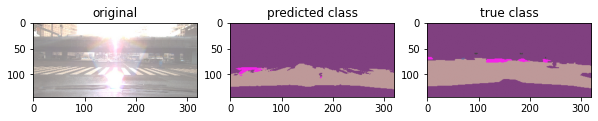

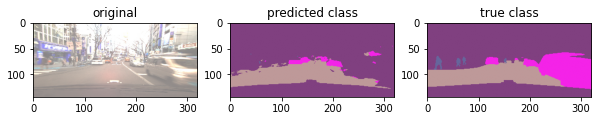

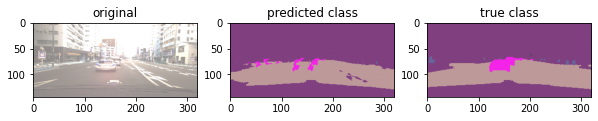

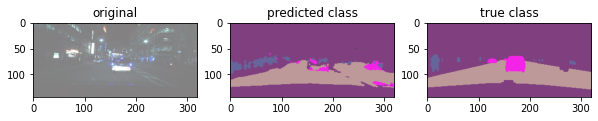

In [28]:
CLASS_NAMES = ("None", "Sky",
               "Wall",
               "Pole",
               "Road",
               "Sidewalk",
               "Vegetation",
               "Sign",
               "Fence",
               "vehicle",
               "Pedestrian")

BATCH_SIZE = 32
EPOCHS = 200


#######################################################################################################

# colors for segmented classes
colorB = [128, 232, 70, 156, 153, 153,  30,   0,  35, 152, 180,  60,   0, 142, 70, 100, 100, 230,  32]
colorG = [ 64,  35, 70, 102, 153, 153, 170, 220, 142, 251, 130,  20,   0,   0,  0,  60,  80,   0,  11]
colorR = [128, 244, 70, 102, 190, 153, 250, 220, 107, 152,  70, 220, 255,   0,  0,   0,   0,   0, 119]
CLASS_COLOR = list()
for i in range(0, 19):
    CLASS_COLOR.append([colorR[i], colorG[i], colorB[i]])
COLORS = np.array(CLASS_COLOR, dtype="float32")

def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)
    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi == c))
        FP = np.sum( (Yi != c)&(y_predi == c))
        FN = np.sum( (Yi == c)&(y_predi != c))
        IoU = TP/float(TP + FP + FN)
        #print("class {:02.0f}: #TP={:7.0f}, #FP={:7.0f}, #FN={:7.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        print("class (%2d) %12.12s: #TP=%7.0f, #FP=%7.0f, #FN=%7.0f, IoU=%4.3f" % (c, CLASS_NAMES[c],TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    return

def visualize_model_performance(X_test, y_pred1_i, y_test1_i, n_classes):

    for k in range(5):

        i = k
        img_is  = (X_test[i] + 1)*(255.0/2)
        seg = y_pred1_i[i]
        segtest = y_test1_i[i]

        fig = plt.figure(figsize=(10,30))
        ax = fig.add_subplot(1,3,1)
        ax.imshow(img_is/255.0)
        ax.set_title("original")

        ax = fig.add_subplot(1,3,2)
        ax.imshow(give_color_to_seg_img(seg,n_classes))
        ax.set_title("predicted class")

        ax = fig.add_subplot(1,3,3)
        ax.imshow(give_color_to_seg_img(segtest,n_classes))
        ax.set_title("true class")

    plt.show()

visualize_model_performance(X_valid, y_pred2_i, y_test2_i, N_CLASSES)


In [29]:
# colors for segmented classes
colorB = [128, 232, 70, 156, 153, 153,  30,   0,  35, 152, 180,  60,   0, 142, 70, 100, 100, 230,  32]
colorG = [ 64,  35, 70, 102, 153, 153, 170, 220, 142, 251, 130,  20,   0,   0,  0,  60,  80,   0,  11]
colorR = [128, 244, 70, 102, 190, 153, 250, 220, 107, 152,  70, 220, 255,   0,  0,   0,   0,   0, 119]
CLASS_COLOR = list()
for i in range(0, 19):
    CLASS_COLOR.append([colorR[i], colorG[i], colorB[i]])
COLORS = np.array(CLASS_COLOR, dtype="float32")

def give_color_to_seg_img(seg,n_classes):
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    #colors = sns.color_palette("hls", n_classes) #DB
    colors = COLORS #DB
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0]/255.0 ))
        seg_img[:,:,1] += (segc*( colors[c][1]/255.0 ))
        seg_img[:,:,2] += (segc*( colors[c][2]/255.0 ))

    return(seg_img)


now computing IoU over testing data set:
class ( 0)         None: #TP= 719690, #FP=   2251, #FN=    595, IoU=0.996
class ( 1)          Sky: #TP=  22210, #FP=   1419, #FN=    241, IoU=0.930
class ( 2)         Wall: #TP=   1206, #FP=     17, #FN=     16, IoU=0.973
class ( 3)         Pole: #TP=   8896, #FP=    151, #FN=   1226, IoU=0.866
class ( 4)         Road: #TP= 165246, #FP=    514, #FN=   2274, IoU=0.983
_________________
Mean IoU: 0.950

now computing IoU over validation data set:
(10, 144, 320) (10, 144, 320)
class ( 0)         None: #TP= 330790, #FP=  20562, #FN=  20704, IoU=0.889
class ( 1)          Sky: #TP=   3231, #FP=  10109, #FN=   7640, IoU=0.154
class ( 2)         Wall: #TP=     21, #FP=    165, #FN=    163, IoU=0.060
class ( 3)         Pole: #TP=    370, #FP=   3051, #FN=   2005, IoU=0.068
class ( 4)         Road: #TP=  79150, #FP=  13351, #FN=  16726, IoU=0.725
_________________
Mean IoU: 0.379


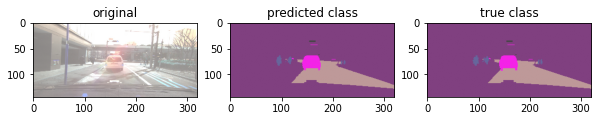

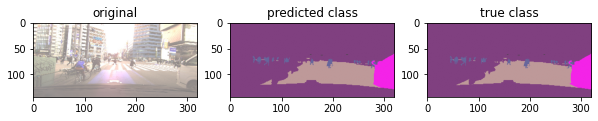

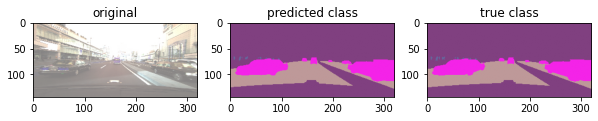

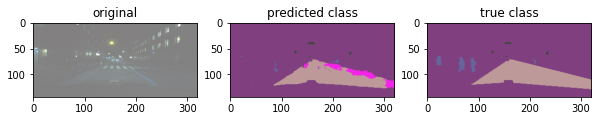

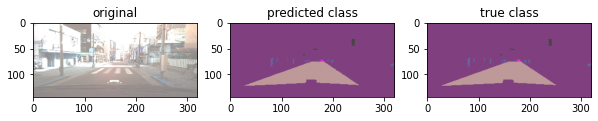

In [ ]:
print("\nnow computing IoU over testing data set:")
y_pred1   = model.predict(X_train)
y_pred1_i = np.argmax(y_pred1, axis=3)
y_test1_i = np.argmax(Y_train, axis=3)
#print(y_test1_i.shape,y_pred1_i.shape)
IoU(y_test1_i, y_pred1_i)

print("\nnow computing IoU over validation data set:")
y_pred2 = model.predict(X_valid)
y_pred2_i = np.argmax(y_pred2, axis=3)
y_test2_i = np.argmax(Y_valid, axis=3)
print(y_test2_i.shape,y_pred2_i.shape)
IoU(y_test2_i,y_pred2_i)


visualize_model_performance(X_train, y_pred1_i, y_test1_i, N_CLASSES)


computing IoU over testing data set:
class ( 0)         None: #TP= 717935, #FP=   2419, #FN=   2350, IoU=0.993
class ( 1)          Sky: #TP=  21879, #FP=    270, #FN=    572, IoU=0.963
class ( 2)         Wall: #TP=   1103, #FP=     75, #FN=    119, IoU=0.850
class ( 3)         Pole: #TP=   9205, #FP=    720, #FN=    917, IoU=0.849
class ( 4)         Road: #TP= 166080, #FP=   1914, #FN=   1440, IoU=0.980
_________________
Mean IoU: 0.927

now computing IoU over validation data set:
class ( 0)         None: #TP= 337349, #FP=  25775, #FN=  14145, IoU=0.894
class ( 1)          Sky: #TP=   2607, #FP=   2250, #FN=   8264, IoU=0.199
class ( 2)         Wall: #TP=     14, #FP=    180, #FN=    170, IoU=0.038
class ( 3)         Pole: #TP=    409, #FP=   2109, #FN=   1966, IoU=0.091
class ( 4)         Road: #TP=  78035, #FP=  12072, #FN=  17841, IoU=0.723
_________________
Mean IoU: 0.389


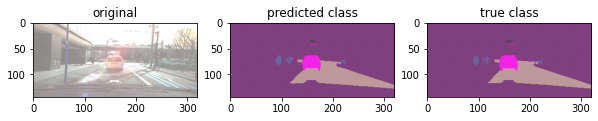

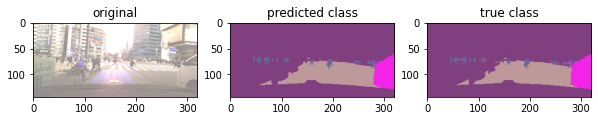

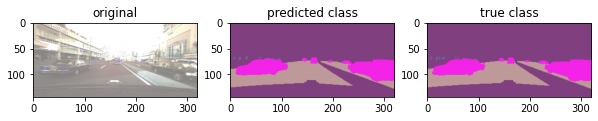

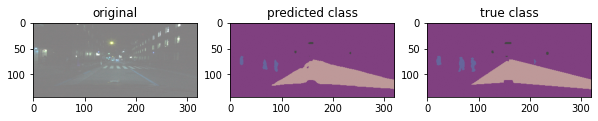

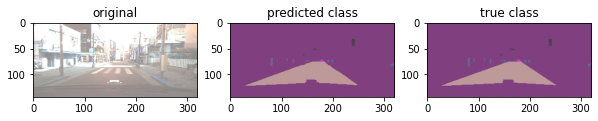

In [32]:
print("\ncomputing IoU over testing data set:")
y_pred1   = model.predict(X_train)
y_pred1_i = np.argmax(y_pred1, axis=3)
y_test1_i = np.argmax(Y_train, axis=3)
#print(y_test1_i.shape,y_pred1_i.shape)
IoU(y_test1_i, y_pred1_i)

print("\nnow computing IoU over validation data set:")
y_pred2 = model.predict(X_valid)
y_pred2_i = np.argmax(y_pred2, axis=3)
y_test2_i = np.argmax(Y_valid, axis=3)
#print(y_test2_i.shape,y_pred2_i.shape)
IoU(y_test2_i,y_pred2_i)
UPSCALE=True
visualize_model_performance(X_train, y_pred1_i, y_test1_i, FINE_N_CLASSES)